### [Market Segment]: Notebook 1 - Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import stats
from collections import Counter
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

pd.set_option('display.width', 1000)

import seaborn as sns
color = sns.color_palette()
sns.set(style="whitegrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Exploration of Raw Data (OR) Engineered Data

data_to_explore = 'raw'
#data_to_explore = 'features'

In [3]:
if data_to_explore == 'raw':
    DATA_FOLDER = './0.datasets/'
    train_explore      = pd.read_csv(os.path.join(DATA_FOLDER, 'AV-Segment-train.csv'))
    test_explore       = pd.read_csv(os.path.join(DATA_FOLDER, 'AV-Segment-test.csv'))
elif data_to_explore == 'features':
    DATA_FOLDER = './1.intermediate/'
    train_explore      = pd.read_csv(os.path.join(DATA_FOLDER, 'AV-Segment-train-feats.csv'))
    test_explore       = pd.read_csv(os.path.join(DATA_FOLDER, 'AV-Segment-test-feats.csv'))
    target_df          = pd.read_csv(os.path.join(DATA_FOLDER, 'AV-Segment-target.csv'))
    
    train_explore = pd.concat([train_explore,target_df],axis=1)

In [4]:
train_explore['source']='train'
test_explore['source']='test'
data = pd.concat([train_explore, test_explore],ignore_index=True)
print (train_explore.shape, test_explore.shape, data.shape)

(8068, 12) (2627, 11) (10695, 12)


In [5]:
train_explore.head().T

,0,1,2,3,4
ID,462809,462643,466315,461735,462669
Gender,Male,Female,Female,Male,Female
Ever_Married,No,Yes,Yes,Yes,Yes
Age,22,38,67,67,40
Graduated,No,Yes,Yes,Yes,Yes
Profession,Healthcare,Engineer,Engineer,Lawyer,Entertainment
Work_Experience,1,NaN,1,0,NaN
Spending_Score,Low,Average,Low,High,High
Family_Size,4,3,1,2,6
Var_1,Cat_4,Cat_4,Cat_6,Cat_6,Cat_6


### Starting EDA

In [6]:
from utility_functions import *

In [7]:
unique_col_values(train_explore)

ID | 8068 | int64
Gender | 2 | object
Ever_Married | 3 | object
Age | 67 | int64
Graduated | 3 | object
Profession | 10 | object
Work_Experience | 16 | float64
Spending_Score | 3 | object
Family_Size | 10 | float64
Var_1 | 8 | object
Segmentation | 4 | object
source | 1 | object


**Insights**
1. No data type changes might be required

In [8]:
print(train_explore.apply(num_missing, axis=0))

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
source               0
dtype: int64


#### Insights

Many columns have null values. Imputation required for:
1. Categorical variables - Ever_Married, Graduated, Profession, Var_1
2. Numerical variables - Work_Experience, Family_Size

**Using basic numerical distribution and value counts to identify the relevant columns & correct datatypes**

In [48]:
var='Family_Size'
train_explore[var].value_counts()
#train_explore['Self_Employed'].value_counts().index[0]

2.000000    2390
3.000000    1497
1.000000    1453
4.000000    1379
5.000000     612
2.850123     335
6.000000     212
7.000000      96
8.000000      50
9.000000      44
Name: Family_Size, dtype: int64

In [14]:
train_explore.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [18]:
# Using the percentile numbers to find out the clipping range & for binning
col = ['Family_Size']
np.nanpercentile(train_explore[col].values, [0,10,25,50,75,90,95,99,100])

array([1., 1., 2., 3., 4., 5., 6., 8., 9.])

1. Work_Experience - No outliers, Mean for imputation
2. Age - No outliers
3. Family_Size - No outliers, Mean for imputation

**0.Performing basic pre-processing-Datatype changes, Drop irrelevant columns, Clip values, Create categories**

In [19]:
# Change Datatypes based on initial analysis

# Family_Size

In [20]:
# Handling Outliers - Clipping numerical values

# Min - 10 percentile, Max - 99 percentile

min_percentile = 1
max_percentile = 99.5

cols_for_clipping = []
                     
for col in cols_for_clipping:
    #new_col = col + '_clipped'
    #new_features_df[new_col] = train_explore[col].values

    llimit = np.nanpercentile(train_explore[col].values, min_percentile)  
    ulimit = np.nanpercentile(train_explore[col].values, max_percentile) 
    train_explore.loc[train_explore[col] < llimit,[col]] = llimit
    train_explore.loc[train_explore[col] > ulimit,[col]] = ulimit

In [21]:
# 1 - Creating new columns from categorical variables
# Item Fat Content
#train_explore['Item_Fat_Content'] = train_explore['Item_Fat_Content'].replace({'LF':'Low Fat',
#                                                             'reg':'Regular',
#                                                             'low fat':'Low Fat'})

# Item Type Combined
#train_explore['Item_Type_Combined'] = train_explore['Item_Identifier'].apply(lambda x: x[0:2])

#Mark non-consumables as separate category in low_fat:
#train_explore.loc[train_explore['Item_Type_Combined']=="NC",'Item_Fat_Content'] = "Non-Edible"

In [22]:
# Reducing categories
# Purpose_Of_Loan
#need = train_explore['Loan_Amount_Term'].value_counts().index[:2]
#train_explore['Loan_Amount_Term'] = np.where(train_explore['Loan_Amount_Term'].isin(need), train_explore['Loan_Amount_Term'], 'Others')

In [24]:
# Replace missing values for categorical features
# Ever_Married
miss_bool = train_explore['Ever_Married'].isnull()
most_frequent = train_explore['Ever_Married'].value_counts().index[0]
train_explore.loc[miss_bool,'Ever_Married'] = most_frequent

# Graduated
miss_bool = train_explore['Graduated'].isnull()
most_frequent = train_explore['Graduated'].value_counts().index[0]
train_explore.loc[miss_bool,'Graduated'] = most_frequent

# Graduated
miss_bool = train_explore['Var_1'].isnull()
most_frequent = train_explore['Var_1'].value_counts().index[0]
train_explore.loc[miss_bool,'Var_1'] = most_frequent

# Profession
miss_bool = train_explore['Profession'].isnull()
train_explore.loc[miss_bool,'Profession'] = 'Others'

In [25]:
# Replace missing values for numerical features
# Work_Experience
miss_bool = train_explore['Work_Experience'].isnull()
mean_value = train_explore['Work_Experience'].mean()
train_explore.loc[miss_bool,'Work_Experience'] = mean_value

# Family_Size
miss_bool = train_explore['Family_Size'].isnull()
mean_value = train_explore['Family_Size'].mean()
train_explore.loc[miss_bool,'Family_Size'] = mean_value

In [26]:
unique_col_values(train_explore)

ID | 8068 | int64
Gender | 2 | object
Ever_Married | 2 | object
Age | 67 | int64
Graduated | 2 | object
Profession | 10 | object
Work_Experience | 16 | float64
Spending_Score | 3 | object
Family_Size | 10 | float64
Var_1 | 7 | object
Segmentation | 4 | object
source | 1 | object


In [27]:
if 1==0: # Select relevant columns for insight generation
    selected_cols = []
    train_explore = train_explore[selected_cols]

In [28]:
unique_col_values(train_explore)

ID | 8068 | int64
Gender | 2 | object
Ever_Married | 2 | object
Age | 67 | int64
Graduated | 2 | object
Profession | 10 | object
Work_Experience | 16 | float64
Spending_Score | 3 | object
Family_Size | 10 | float64
Var_1 | 7 | object
Segmentation | 4 | object
source | 1 | object


In [29]:
print(train_explore.apply(num_missing, axis=0))

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
source             0
dtype: int64


### Checking Train & Test distribution

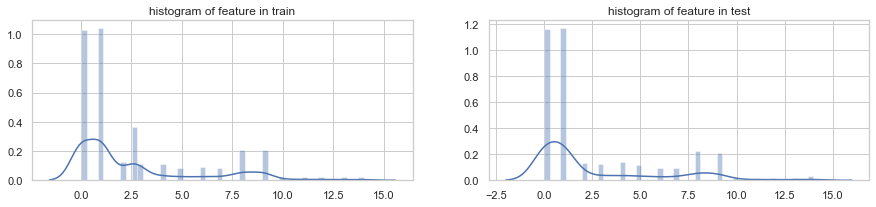

Skew-Train: 1.38
Skew-Test: nan


In [30]:
# Checking distribution of numerical variables in train & test
def examine_distribution(train, test):
    plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(3,2, width_ratios=(2,2))
    
    ax = plt.subplot(gs[0])
    sns.distplot(train, bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature in train')

    ax = plt.subplot(gs[1])
    sns.distplot(test, bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature in test')

    plt.show()


# Can set the variable for which the distribution is to be found
var = 'Work_Experience'

train_dist_df = train_explore[[var]].copy()
test_dist_df = test_explore[[var]].copy()

train_values = train_dist_df[var].values.reshape(-1,1)
test_values = test_dist_df[var].values.reshape(-1,1)

examine_distribution(train_values,test_values)
print("Skew-Train: %0.2f" %stats.skew(train_values))
print("Skew-Test: %0.2f" %stats.skew(test_values))

### Exploring Categorical Variables

In [31]:
#Value Counts - Feel for number of records in each category

#Filter categorical variables
categorical_columns = [x for x in train_explore.dtypes.index if train_explore.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['ID']]
#Print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of Categories for variable %s'%col)
    print (train_explore[col].value_counts())


Frequency of Categories for variable Gender
Male      4417
Female    3651
Name: Gender, dtype: int64

Frequency of Categories for variable Ever_Married
Yes    4783
No     3285
Name: Ever_Married, dtype: int64

Frequency of Categories for variable Graduated
Yes    5046
No     3022
Name: Graduated, dtype: int64

Frequency of Categories for variable Profession
Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Others            124
Name: Profession, dtype: int64

Frequency of Categories for variable Spending_Score
Low        4878
Average    1974
High       1216
Name: Spending_Score, dtype: int64

Frequency of Categories for variable Var_1
Cat_6    5314
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
Name: Var_1, dtype: int64

Frequency of Categories for variable Segmentation
D    2268
A    1972
C    1970
B  

<Figure size 864x432 with 0 Axes>

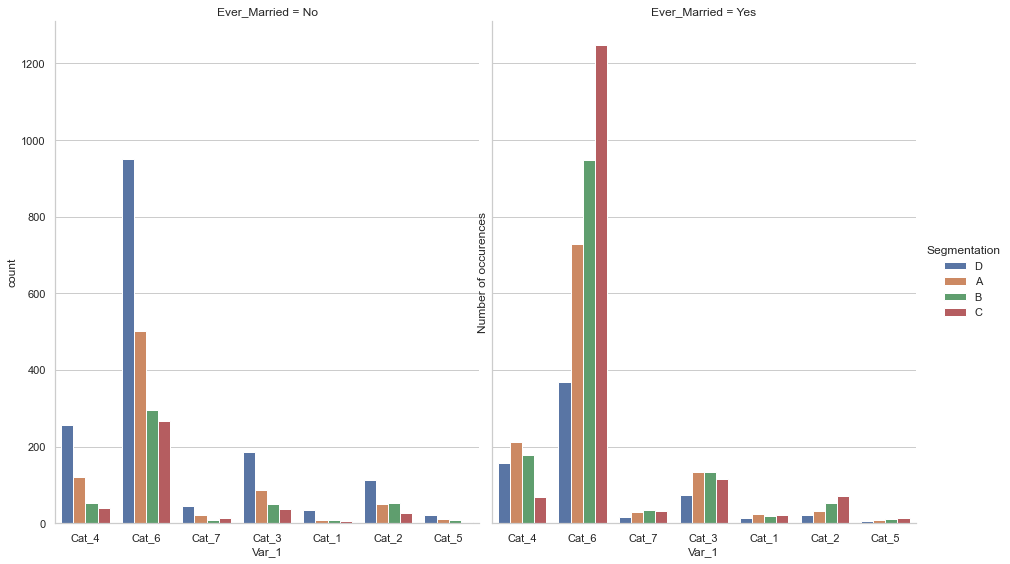

In [33]:
# Visualizing Relationship of categorical variables with hue and another categorical variable as facet grid

xvar = 'Var_1' # Var_1,Profession
hue = 'Segmentation'
col = 'Ever_Married' # Gender,Ever_Married, Graduated, Spending_Score

plt.figure(figsize=(12,6))
ax = sns.catplot(x=xvar, hue=hue, col=col,data=train_explore, kind="count",height=8, aspect=.8);

plt.xlabel(xvar, fontsize=12)
plt.ylabel('Number of occurences', fontsize=12)
plt.show()

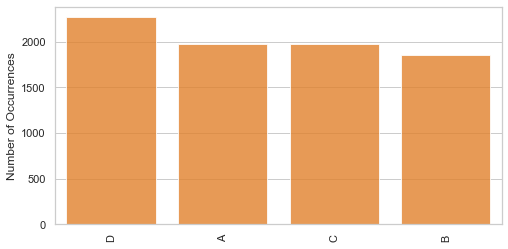

In [34]:
#Bar plots - Feel for number of records in each category

var = 'Segmentation'

# Method 1
#train_explore[var].value_counts(sort=False).plot.bar()

# Method 2
counts = np.round(train_explore[var].value_counts(normalize=False),2)
plt.figure(figsize=(8,4))
ax=sns.barplot(counts.index, counts.values, alpha=0.8, color=color[1])

#for p in ax.patches:
#    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.005))

plt.ylabel('Number of Occurrences', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#plt.xlabel(var, fontsize=12, vertical)
plt.show()

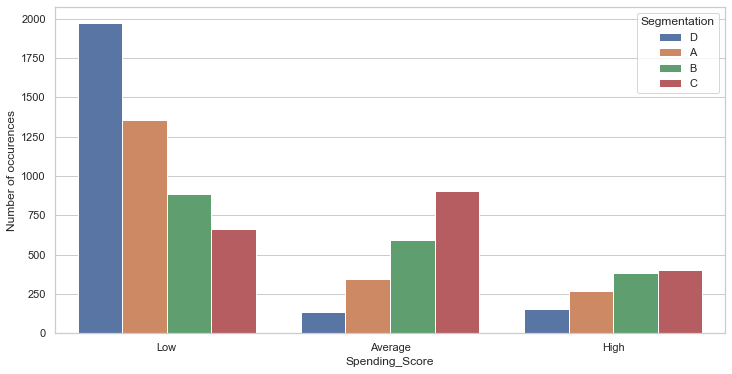

In [40]:
# Visualizing Relationship of categorical variables with hue as another categorical variable

xvar = 'Spending_Score' #Var_1,Profession,Gender,Ever_Married, Graduated, Spending_Score

hue = 'Segmentation'

plt.figure(figsize=(12,6))
ax = sns.countplot(x=xvar,data=train_explore,hue=hue)

plt.xlabel(xvar, fontsize=12)
plt.ylabel('Number of occurences', fontsize=12)
plt.show()

### Exploring Numerical variables

In [41]:
train_explore.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,8068.0,463479.214551,2595.381232,458982.0,461240.75,463472.500000,465744.25,467974.0
Age,8068.0,43.466906,16.711696,18.0,30.00,40.000000,53.00,89.0
Work_Experience,8068.0,2.641663,3.226972,0.0,0.00,1.000000,4.00,14.0
Family_Size,8068.0,2.850123,1.499278,1.0,2.00,2.850123,4.00,9.0


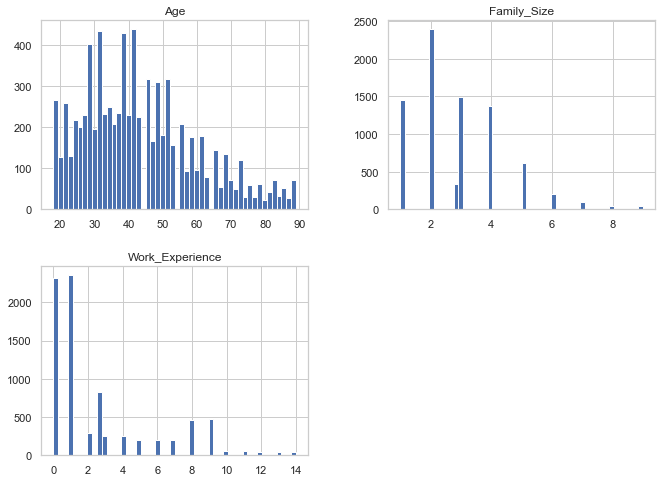

In [43]:
# Histograms
hist_columns = ['Age','Work_Experience','Family_Size']
train_explore[hist_columns].hist(bins=50, figsize=(11,8))
plt.show()

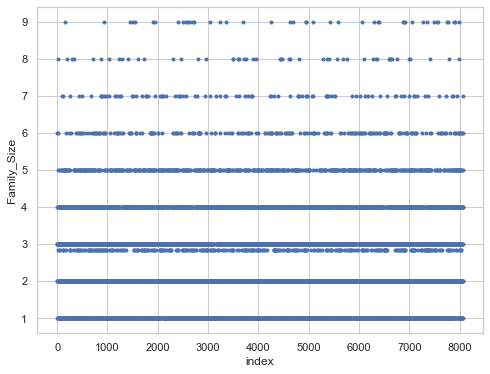

In [47]:
# Numerical values - Distribution
plt.figure(figsize=(8,6))
sort='No'
clipped='No'

var = 'Family_Size' #'Age','Work_Experience','Family_Size'

dist_df = train_explore[[var]].copy()

if clipped == 'Yes':
    llimit = np.nanpercentile(dist_df[var].values, 1)  #Here 1% is the threshold but that number can be changed
    ulimit = np.nanpercentile(dist_df[var].values, 99) #Here 99% is the threshold but that number can be changed
    dist_df.loc[dist_df[var] < llimit,[var]] = llimit
    dist_df.loc[dist_df[var] > ulimit,[var]] = ulimit
    
if sort=="Yes":
    plt.scatter(range(dist_df.shape[0]), np.sort(dist_df[var].values))
elif sort=="No":
    plt.plot(dist_df[var].values,'.')
    
plt.xlabel('index', fontsize=12)
plt.ylabel(var, fontsize=12)
plt.show()

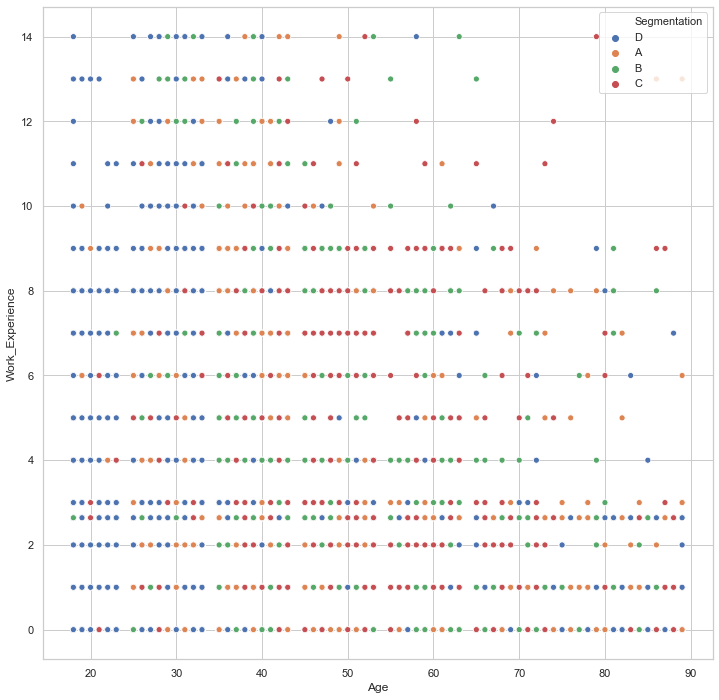

In [50]:
# Scatter plot with hue to differentiate categories
plt.figure(figsize=(12,12))

xvar = 'Age'
yvar = 'Work_Experience'

sns.scatterplot(data=train_explore, x=xvar, y=yvar, hue='Segmentation')
plt.show()

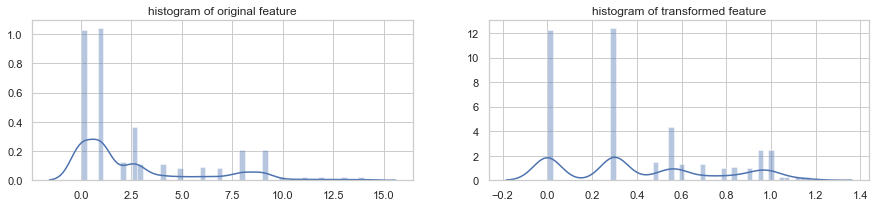

Skew-Before: 1.38
Skew-After: 0.42
Kurtosis-Before: 0.93
Kurtosis-After: -1.02


In [56]:
# Numerical - Checking Transformation of Variable
transform = 'log'
clipped='No'

var = 'Work_Experience'       #log
#var = 'Age'                  #log


dist_df = train_explore[[var]].copy()

if clipped == 'Yes':
    llimit = np.nanpercentile(dist_df[var].values, 1)  #Here 1% is the threshold but that number can be changed
    ulimit = np.nanpercentile(dist_df[var].values, 99) #Here 99% is the threshold but that number can be changed
    dist_df.loc[dist_df[var] < llimit,[var]] = llimit
    dist_df.loc[dist_df[var] > ulimit,[var]] = ulimit

original_values = dist_df[var].values.reshape(-1,1)

if transform == 'boxcox':
    transformed_values,lam = stats.boxcox(original_values)
    print(lam)
elif transform == 'log':
    transformed_values = np.log10(original_values+1)
elif transform == 'sqrt':    
    transformed_values = np.sqrt(original_values)
elif transform == 'square':    
    transformed_values = np.power(original_values,2)
elif transform == 'cube':    
    transformed_values = np.power(original_values,3)
elif transform == 'scaler':
    transformed_values = MinMaxScaler(feature_range=(0, 1)).fit_transform(original_values)
elif transform == 'standardizer':
    transformed_values = StandardScaler().fit_transform(original_values)
elif transform == 'normalizer':
    transformed_values = Normalizer().fit_transform(original_values)
elif transform == "none":
    transformed_values = original_values
    
examine_transform(original_values,transformed_values)
print("Skew-Before: %0.2f" %stats.skew(original_values))
print("Skew-After: %0.2f" %stats.skew(transformed_values))

print("Kurtosis-Before: %0.2f" %stats.kurtosis(original_values))
print("Kurtosis-After: %0.2f" %stats.kurtosis(transformed_values))

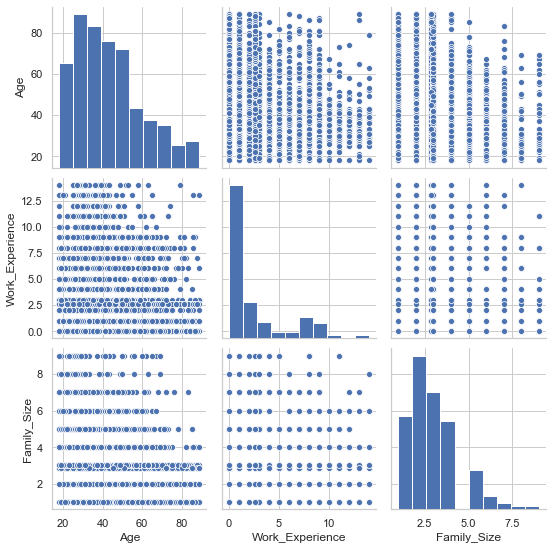

In [57]:
#Numerical - Pairplots

pairplot_columns = ['Age','Work_Experience','Family_Size']
sns.pairplot(train_explore[pairplot_columns].dropna())
plt.show()

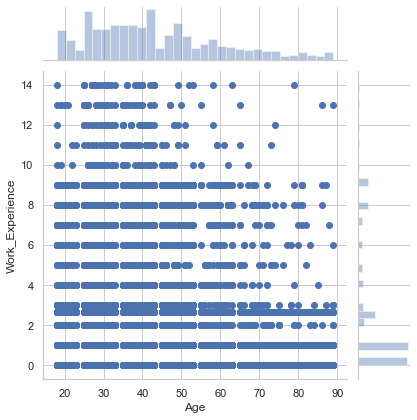

In [58]:
# Numerical - Drilling down to specific relationships
xvar = 'Age'
yvar = 'Work_Experience'
type='joint'

ymin = train_explore[yvar].min()
ymax = train_explore[yvar].max()

if type == 'lm':
    sns.lmplot(xvar, yvar, data=train_explore, fit_reg=True)
elif type == "joint":
    sns.jointplot(xvar, yvar, data=train_explore.dropna(), kind='scatter')
elif type == "scatter":
    pd.concat([train_explore[xvar], train_explore[yvar]], axis=1).plot.scatter(x=xvar, y=yvar, ylim=(ymin,ymax));

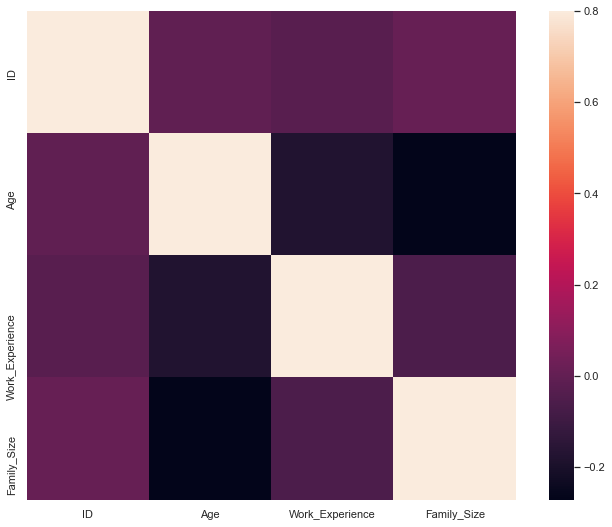

In [59]:
#correlation matrix - explorethe correlation among all numerical variables
corrmat = train_explore.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

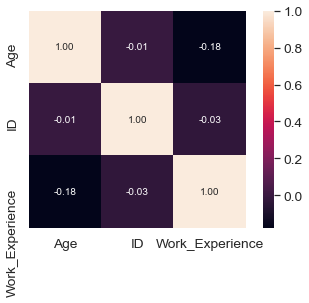

In [61]:
# Exploring correlations for specific numerical variable
k = 3 #number of variables for heatmap

focus_col = ['Age']
cols = corrmat.nlargest(k, focus_col)[focus_col].index
cm = np.corrcoef(train_explore[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Exploring Numerical & Categorical Variables Together

[Text(0.5, 3.200000000000003, "['Graduated']")]

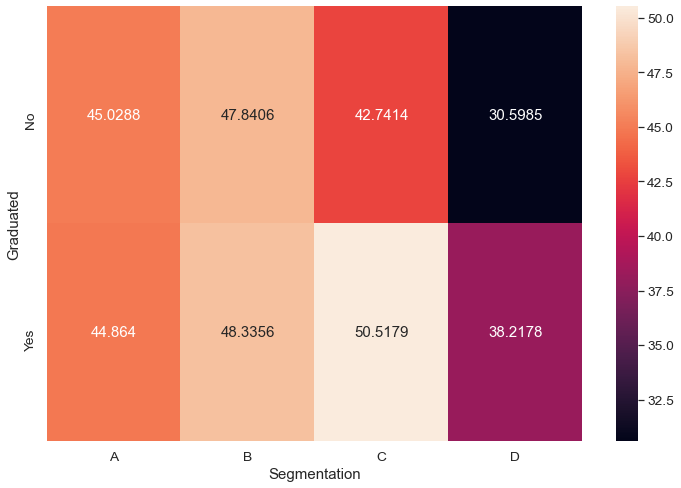

In [68]:
# Pivot Tables - To start understanding relationships between variables

plt.figure(figsize=(12,8))
xvar = ['Graduated'] #Var_1,Profession,Gender,Ever_Married, Graduated, Spending_Score
yvar = ['Segmentation']
calc_field = 'Age' # ID,Age,Work_Experience,Family_Size
calc_type = 'mean' #calc_type = ['count','mean','max','min','unique','sum']

effic_size_pivot = pivot_count(train_explore,xvar,yvar,calc_field,calc_type=calc_type)


sns.heatmap(effic_size_pivot, annot=True, fmt='g')
ax.set(xlabel=xvar)
#sns.plt.title('Pivot Table \n')

In [69]:
# Pivot Table
func = lambda x: 100*x.count()/train_explore.shape[0]

temp = train_explore.copy()

temp.pivot_table(index=['Ever_Married'] ,         #<features-for-rows>
                          columns=['Segmentation'],    #<features-for-columns>
                          values=['ID'],                   #<feature-for-cells>
                          #aggfunc={"Credit_Score_Levels":len}, #<aggregate-function>
                          aggfunc=func,
                          #aggfunc=np.mean,
                          margins=True)  

ID                                             
Segmentation          A          B          C          D         All
Ever_Married                                                        
No             9.928111   5.937035   4.933069  19.918195   40.716411
Yes           14.514130  17.092216  19.484383   8.192861   59.283589
All           24.442241  23.029251  24.417452  28.111056  100.000000

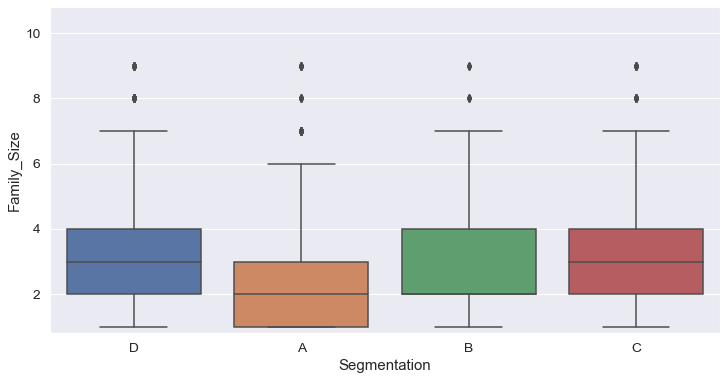

In [72]:
# Categorical (X) vs Numerical (Y) - Box plots - To understand the distribution in each category

xvar = 'Segmentation'
yvar = 'Family_Size' # Age,Work_Experience,Family_Size

ymin = train_explore[yvar].min()
ymax = train_explore[yvar].max()

type = 'box' # Boxplot
#type = 'violin' #Violin
 
f, ax = plt.subplots(figsize=(12, 6))

if type == 'box':
    fig = sns.boxplot(x=xvar, y=yvar, data=train_explore)
elif type == 'violin':
    fig = sns.violinplot(x=xvar, y=yvar, data=train_explore)
    
fig.axis(ymin=0.8*ymin, ymax=1.2*ymax);

In [73]:
# Categorical with Numerical - Aggregate count to find average values of numerical variable grouped by category variable
def agg_avg(df, group_field, calc_field):
    grouped = df.groupby(group_field, as_index=False)[calc_field].mean()
    #grouped = grouped.sort(calc_field, ascending = False)
    grouped.columns = [group_field, 'Avg_' + str(calc_field)]
    return grouped

[Text(0.5, 0, 'Segmentation')]

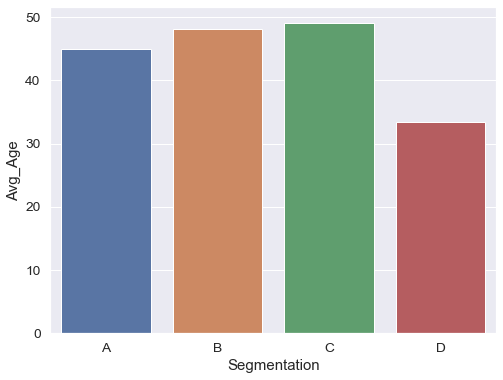

In [75]:
# Categorical with Numerical - Aggregate count to find average values of numerical variable grouped by category variable
plt.figure(figsize=(8,6))
group_var = 'Segmentation'
calc_var = 'Age'

#loan_amount_avg = agg_avg(train_explore, 'Loan_Status', 'LoanAmount')
calc_var_avg = agg_avg(train_explore, group_var, calc_var)

yvar = 'Avg_' + calc_var
#ax = sns.barplot(data=loan_amount_avg, x='Loan_Status', y='Avg LoanAmount')
ax = sns.barplot(data=calc_var_avg, x=group_var, y=yvar)
ax.set(xlabel=group_var)
#sns.plt.title('Average Value \n')